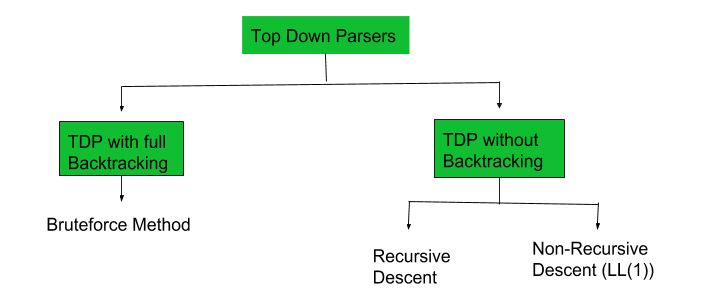

In [ ]:
def get_next_token(expression, index):
    token = None

    while index < len(expression) and expression[index].isspace():
        index += 1

    if index < len(expression) and expression[index].isdigit():
        token = ("INTEGER", "")
        while index < len(expression) and expression[index].isdigit():
            token = ("INTEGER", token[1] + expression[index])
            index += 1
    elif index < len(expression) and expression[index] in "+-*/":
        token = ("OPERATOR", expression[index])
        index += 1
    elif index == len(expression):
        token = ("EOL",)

    return token, index


def parse_expression(token, index):
    if token[0] == "INTEGER":
        print(f"INTEGER: {token[1]}")
        token, index = get_next_token(expression, index)

    while token and token[0] == "OPERATOR":
        print(f"OPERATOR: {token[1]}")
        token, index = get_next_token(expression, index)

        if token and token[0] == "INTEGER":
            print(f"INTEGER: {token[1]}")
            token, index = get_next_token(expression, index)
        else:
            print("Error: Invalid syntax.")
            break

    if not token:
        print("Parsing completed successfully.")


if __name__ == "__main__":
    expression = input("Enter an expressiona(integers only and operator): ")
    index = 0
    initial_token, index = get_next_token(expression, index)
    parse_expression(initial_token, index)


https://www.geeksforgeeks.org/compiler-design-ll1-parser-in-python/

In [ ]:
# LL(1) parser code in python

def removeLeftRecursion(rulesDiction):
	# for rule: A->Aa|b
	# result: A->bA',A'->aA'|#

	# 'store' has new rules to be added
	store = {}
	# traverse over rules
	for lhs in rulesDiction:
		# alphaRules stores subrules with left-recursion
		# betaRules stores subrules without left-recursion
		alphaRules = []
		betaRules = []
		# get rhs for current lhs
		allrhs = rulesDiction[lhs]
		for subrhs in allrhs:
			if subrhs[0] == lhs:
				alphaRules.append(subrhs[1:])
			else:
				betaRules.append(subrhs)
		# alpha and beta containing subrules are separated
		# now form two new rules
		if len(alphaRules) != 0:
			# to generate new unique symbol
			# add ' till unique not generated
			lhs_ = lhs + "'"
			while (lhs_ in rulesDiction.keys()) \
					or (lhs_ in store.keys()):
				lhs_ += "'"
			# make beta rule
			for b in range(0, len(betaRules)):
				betaRules[b].append(lhs_)
			rulesDiction[lhs] = betaRules
			# make alpha rule
			for a in range(0, len(alphaRules)):
				alphaRules[a].append(lhs_)
			alphaRules.append(['#'])
			# store in temp dict, append to
			# - rulesDiction at end of traversal
			store[lhs_] = alphaRules
	# add newly generated rules generated
	# - after removing left recursion
	for left in store:
		rulesDiction[left] = store[left]
	return rulesDiction


def LeftFactoring(rulesDiction):
	# for rule: A->aDF|aCV|k
	# result: A->aA'|k, A'->DF|CV

	# newDict stores newly generated
	# - rules after left factoring
	newDict = {}
	# iterate over all rules of dictionary
	for lhs in rulesDiction:
		# get rhs for given lhs
		allrhs = rulesDiction[lhs]
		# temp dictionary helps detect left factoring
		temp = dict()
		for subrhs in allrhs:
			if subrhs[0] not in list(temp.keys()):
				temp[subrhs[0]] = [subrhs]
			else:
				temp[subrhs[0]].append(subrhs)
		# if value list count for any key in temp is > 1,
		# - it has left factoring
		# new_rule stores new subrules for current LHS symbol
		new_rule = []
		# temp_dict stores new subrules for left factoring
		tempo_dict = {}
		for term_key in temp:
			# get value from temp for term_key
			allStartingWithTermKey = temp[term_key]
			if len(allStartingWithTermKey) > 1:
				# left factoring required
				# to generate new unique symbol
				# - add ' till unique not generated
				lhs_ = lhs + "'"
				while (lhs_ in rulesDiction.keys()) \
						or (lhs_ in tempo_dict.keys()):
					lhs_ += "'"
				# append the left factored result
				new_rule.append([term_key, lhs_])
				# add expanded rules to tempo_dict
				ex_rules = []
				for g in temp[term_key]:
					ex_rules.append(g[1:])
				tempo_dict[lhs_] = ex_rules
			else:
				# no left factoring required
				new_rule.append(allStartingWithTermKey[0])
		# add original rule
		newDict[lhs] = new_rule
		# add newly generated rules after left factoring
		for key in tempo_dict:
			newDict[key] = tempo_dict[key]
	return newDict


# calculation of first
# epsilon is denoted by '#' (semi-colon)

# pass rule in first function
def first(rule):
	global rules, nonterm_userdef, \
		term_userdef, diction, firsts
	# recursion base condition
	# (for terminal or epsilon)
	if len(rule) != 0 and (rule is not None):
		if rule[0] in term_userdef:
			return rule[0]
		elif rule[0] == '#':
			return '#'

	# condition for Non-Terminals
	if len(rule) != 0:
		if rule[0] in list(diction.keys()):
			# fres temporary list of result
			fres = []
			rhs_rules = diction[rule[0]]
			# call first on each rule of RHS
			# fetched (& take union)
			for itr in rhs_rules:
				indivRes = first(itr)
				if type(indivRes) is list:
					for i in indivRes:
						fres.append(i)
				else:
					fres.append(indivRes)

			# if no epsilon in result
			# - received return fres
			if '#' not in fres:
				return fres
			else:
				# apply epsilon
				# rule => f(ABC)=f(A)-{e} U f(BC)
				newList = []
				fres.remove('#')
				if len(rule) > 1:
					ansNew = first(rule[1:])
					if ansNew != None:
						if type(ansNew) is list:
							newList = fres + ansNew
						else:
							newList = fres + [ansNew]
					else:
						newList = fres
					return newList
				# if result is not already returned
				# - control reaches here
				# lastly if eplison still persists
				# - keep it in result of first
				fres.append('#')
				return fres


# calculation of follow
# use 'rules' list, and 'diction' dict from above

# follow function input is the split result on
# - Non-Terminal whose Follow we want to compute
def follow(nt):
	global start_symbol, rules, nonterm_userdef, \
		term_userdef, diction, firsts, follows
	# for start symbol return $ (recursion base case)

	solset = set()
	if nt == start_symbol:
		# return '$'
		solset.add('$')

	# check all occurrences
	# solset - is result of computed 'follow' so far

	# For input, check in all rules
	for curNT in diction:
		rhs = diction[curNT]
		# go for all productions of NT
		for subrule in rhs:
			if nt in subrule:
				# call for all occurrences on
				# - non-terminal in subrule
				while nt in subrule:
					index_nt = subrule.index(nt)
					subrule = subrule[index_nt + 1:]
					# empty condition - call follow on LHS
					if len(subrule) != 0:
						# compute first if symbols on
						# - RHS of target Non-Terminal exists
						res = first(subrule)
						# if epsilon in result apply rule
						# - (A->aBX)- follow of -
						# - follow(B)=(first(X)-{ep}) U follow(A)
						if '#' in res:
							newList = []
							res.remove('#')
							ansNew = follow(curNT)
							if ansNew != None:
								if type(ansNew) is list:
									newList = res + ansNew
								else:
									newList = res + [ansNew]
							else:
								newList = res
							res = newList
					else:
						# when nothing in RHS, go circular
						# - and take follow of LHS
						# only if (NT in LHS)!=curNT
						if nt != curNT:
							res = follow(curNT)

					# add follow result in set form
					if res is not None:
						if type(res) is list:
							for g in res:
								solset.add(g)
						else:
							solset.add(res)
	return list(solset)


def computeAllFirsts():
	global rules, nonterm_userdef, \
		term_userdef, diction, firsts
	for rule in rules:
		k = rule.split("->")
		# remove un-necessary spaces
		k[0] = k[0].strip()
		k[1] = k[1].strip()
		rhs = k[1]
		multirhs = rhs.split('|')
		# remove un-necessary spaces
		for i in range(len(multirhs)):
			multirhs[i] = multirhs[i].strip()
			multirhs[i] = multirhs[i].split()
		diction[k[0]] = multirhs

	print(f"\nRules: \n")
	for y in diction:
		print(f"{y}->{diction[y]}")
	print(f"\nAfter elimination of left recursion:\n")

	diction = removeLeftRecursion(diction)
	for y in diction:
		print(f"{y}->{diction[y]}")
	print("\nAfter left factoring:\n")

	diction = LeftFactoring(diction)
	for y in diction:
		print(f"{y}->{diction[y]}")

	# calculate first for each rule
	# - (call first() on all RHS)
	for y in list(diction.keys()):
		t = set()
		for sub in diction.get(y):
			res = first(sub)
			if res != None:
				if type(res) is list:
					for u in res:
						t.add(u)
				else:
					t.add(res)

		# save result in 'firsts' list
		firsts[y] = t

	print("\nCalculated firsts: ")
	key_list = list(firsts.keys())
	index = 0
	for gg in firsts:
		print(f"first({key_list[index]}) "
			f"=> {firsts.get(gg)}")
		index += 1


def computeAllFollows():
	global start_symbol, rules, nonterm_userdef,\
		term_userdef, diction, firsts, follows
	for NT in diction:
		solset = set()
		sol = follow(NT)
		if sol is not None:
			for g in sol:
				solset.add(g)
		follows[NT] = solset

	print("\nCalculated follows: ")
	key_list = list(follows.keys())
	index = 0
	for gg in follows:
		print(f"follow({key_list[index]})"
			f" => {follows[gg]}")
		index += 1


# create parse table
def createParseTable():
	import copy
	global diction, firsts, follows, term_userdef
	print("\nFirsts and Follow Result table\n")

	# find space size
	mx_len_first = 0
	mx_len_fol = 0
	for u in diction:
		k1 = len(str(firsts[u]))
		k2 = len(str(follows[u]))
		if k1 > mx_len_first:
			mx_len_first = k1
		if k2 > mx_len_fol:
			mx_len_fol = k2

	print(f"{{:<{10}}} "
		f"{{:<{mx_len_first + 5}}} "
		f"{{:<{mx_len_fol + 5}}}"
		.format("Non-T", "FIRST", "FOLLOW"))
	for u in diction:
		print(f"{{:<{10}}} "
			f"{{:<{mx_len_first + 5}}} "
			f"{{:<{mx_len_fol + 5}}}"
			.format(u, str(firsts[u]), str(follows[u])))

	# create matrix of row(NT) x [col(T) + 1($)]
	# create list of non-terminals
	ntlist = list(diction.keys())
	terminals = copy.deepcopy(term_userdef)
	terminals.append('$')

	# create the initial empty state of ,matrix
	mat = []
	for x in diction:
		row = []
		for y in terminals:
			row.append('')
		# of $ append one more col
		mat.append(row)

	# Classifying grammar as LL(1) or not LL(1)
	grammar_is_LL = True

	# rules implementation
	for lhs in diction:
		rhs = diction[lhs]
		for y in rhs:
			res = first(y)
			# epsilon is present,
			# - take union with follow
			if '#' in res:
				if type(res) == str:
					firstFollow = []
					fol_op = follows[lhs]
					if fol_op is str:
						firstFollow.append(fol_op)
					else:
						for u in fol_op:
							firstFollow.append(u)
					res = firstFollow
				else:
					res.remove('#')
					res = list(res) +\
						list(follows[lhs])
			# add rules to table
			ttemp = []
			if type(res) is str:
				ttemp.append(res)
				res = copy.deepcopy(ttemp)
			for c in res:
				xnt = ntlist.index(lhs)
				yt = terminals.index(c)
				if mat[xnt][yt] == '':
					mat[xnt][yt] = mat[xnt][yt] \
								+ f"{lhs}->{' '.join(y)}"
				else:
					# if rule already present
					if f"{lhs}->{y}" in mat[xnt][yt]:
						continue
					else:
						grammar_is_LL = False
						mat[xnt][yt] = mat[xnt][yt] \
									+ f",{lhs}->{' '.join(y)}"

	# final state of parse table
	print("\nGenerated parsing table:\n")
	frmt = "{:>12}" * len(terminals)
	print(frmt.format(*terminals))

	j = 0
	for y in mat:
		frmt1 = "{:>12}" * len(y)
		print(f"{ntlist[j]} {frmt1.format(*y)}")
		j += 1

	return (mat, grammar_is_LL, terminals)


def validateStringUsingStackBuffer(parsing_table, grammarll1,
								table_term_list, input_string,
								term_userdef,start_symbol):

	print(f"\nValidate String => {input_string}\n")

	# for more than one entries
	# - in one cell of parsing table
	if grammarll1 == False:
		return f"\nInput String = " \
			f"\"{input_string}\"\n" \
			f"Grammar is not LL(1)"

	# implementing stack buffer

	stack = [start_symbol, '$']
	buffer = []

	# reverse input string store in buffer
	input_string = input_string.split()
	input_string.reverse()
	buffer = ['$'] + input_string

	print("{:>20} {:>20} {:>20}".
		format("Buffer", "Stack","Action"))

	while True:
		# end loop if all symbols matched
		if stack == ['$'] and buffer == ['$']:
			print("{:>20} {:>20} {:>20}"
				.format(' '.join(buffer),
						' '.join(stack),
						"Valid"))
			return "\nValid String!"
		elif stack[0] not in term_userdef:
			# take font of buffer (y) and tos (x)
			x = list(diction.keys()).index(stack[0])
			y = table_term_list.index(buffer[-1])
			if parsing_table[x][y] != '':
				# format table entry received
				entry = parsing_table[x][y]
				print("{:>20} {:>20} {:>25}".
					format(' '.join(buffer),
							' '.join(stack),
							f"T[{stack[0]}][{buffer[-1]}] = {entry}"))
				lhs_rhs = entry.split("->")
				lhs_rhs[1] = lhs_rhs[1].replace('#', '').strip()
				entryrhs = lhs_rhs[1].split()
				stack = entryrhs + stack[1:]
			else:
				return f"\nInvalid String! No rule at " \
					f"Table[{stack[0]}][{buffer[-1]}]."
		else:
			# stack top is Terminal
			if stack[0] == buffer[-1]:
				print("{:>20} {:>20} {:>20}"
					.format(' '.join(buffer),
							' '.join(stack),
							f"Matched:{stack[0]}"))
				buffer = buffer[:-1]
				stack = stack[1:]
			else:
				return "\nInvalid String! " \
					"Unmatched terminal symbols"


# DRIVER CODE - MAIN

# NOTE: To test any of the sample sets, uncomment ->
# 'rules' list, 'nonterm_userdef' list, 'term_userdef' list
# and for any String validation uncomment following line with
# 'sample_input_String' variable.

sample_input_string = None

# sample set 1 (Result: Not LL(1))
# rules=["A -> S B | B",
#	 "S -> a | B c | #",
#	 "B -> b | d"]
# nonterm_userdef=['A','S','B']
# term_userdef=['a','c','b','d']
# sample_input_string="b c b"

# sample set 2 (Result: LL(1))
# rules=["S -> A | B C",
#	 "A -> a | b",
#	 "B -> p | #",
#	 "C -> c"]
# nonterm_userdef=['A','S','B','C']
# term_userdef=['a','c','b','p']
# sample_input_string="p c"

# sample set 3 (Result: LL(1))
# rules=["S -> A B | C",
#	 "A -> a | b | #",
#	 "B-> p | #",
#	 "C -> c"]
# nonterm_userdef=['A','S','B','C']
# term_userdef=['a','c','b','p']
# sample_input_string="a c b"

# sample set 4 (Result: Not LL(1))
# rules = ["S -> A B C | C",
#		 "A -> a | b B | #",
#		 "B -> p | #",
#		 "C -> c"]
# nonterm_userdef=['A','S','B','C']
# term_userdef=['a','c','b','p']
# sample_input_string="b p p c"

# sample set 5 (With left recursion)
# rules=["A -> B C c | g D B",
#	 "B -> b C D E | #",
#	 "C -> D a B | c a",
#	 "D -> # | d D",
#	 "E -> E a f | c"
#	 ]
# nonterm_userdef=['A','B','C','D','E']
# term_userdef=["a","b","c","d","f","g"]
# sample_input_string="b a c a c"

# sample set 6
# rules=["E -> T E'",
#	 "E' -> + T E' | #",
#	 "T -> F T'",
#	 "T' -> * F T' | #",
#	 "F -> ( E ) | id"
# ]
# nonterm_userdef=['E','E\'','F','T','T\'']
# term_userdef=['id','+','*','(',')']
# sample_input_string="id * * id"
# example string 1
# sample_input_string="( id * id )"
# example string 2
# sample_input_string="( id ) * id + id"

# sample set 7 (left factoring & recursion present)
rules=["S -> A k O",
	"A -> A d | a B | a C",
	"C -> c",
	"B -> b B C | r"]

nonterm_userdef=['A','B','C']
term_userdef=['k','O','d','a','c','b','r']
sample_input_string="a r k O"

# sample set 8 (Multiple char symbols T & NT)
# rules = ["S -> NP VP",
#		 "NP -> P | PN | D N",
#		 "VP -> V NP",
#		 "N -> championship | ball | toss",
#		 "V -> is | want | won | played",
#		 "P -> me | I | you",
#		 "PN -> India | Australia | Steve | John",
#		 "D -> the | a | an"]
#
# nonterm_userdef = ['S', 'NP', 'VP', 'N', 'V', 'P', 'PN', 'D']
# term_userdef = ["championship", "ball", "toss", "is", "want",
#				 "won", "played", "me", "I", "you", "India",
#				 "Australia","Steve", "John", "the", "a", "an"]
# sample_input_string = "India won the championship"

# diction - store rules inputted
# firsts - store computed firsts
diction = {}
firsts = {}
follows = {}

# computes all FIRSTs for all non terminals
computeAllFirsts()
# assuming first rule has start_symbol
# start symbol can be modified in below line of code
start_symbol = list(diction.keys())[0]
# computes all FOLLOWs for all occurrences
computeAllFollows()
# generate formatted first and follow table
# then generate parse table

(parsing_table, result, tabTerm) = createParseTable()

# validate string input using stack-buffer concept
if sample_input_string != None:
	validity = validateStringUsingStackBuffer(parsing_table, result,
											tabTerm, sample_input_string,
											term_userdef,start_symbol)
	print(validity)
else:
	print("\nNo input String detected")


In [ ]:
from collections import OrderedDict

def isterminal(char):
    if(char.isupper() or char == "`"):
        return False
    else:
        return True

def insert(grammar, lhs, rhs):
    if(lhs in grammar and rhs not in grammar[lhs] and grammar[lhs] != "null"):
        grammar[lhs].append(rhs)
    elif(lhs not in grammar or grammar[lhs] == "null"):
        grammar[lhs] = [rhs]
    return grammar
	
def first(lhs, grammar, grammar_first):
    rhs = grammar[lhs]
    for i in rhs:
        k = 0
        flag = 0
        current = []
        confirm = 0
        flog = 0
        if(lhs in grammar and "`" in grammar_first[lhs]):
            flog = 1
        while(1):	
            check = []
            if(k>=len(i)):
                if(len(current)==0 or flag == 1 or confirm == k or flog == 1):
                    grammar_first = insert(grammar_first, lhs, "`")
                break				
            if(i[k].isupper()):
                if(grammar_first[i[k]] == "null"):
                    grammar_first = first(i[k], grammar, grammar_first)
                   # print("state ", lhs, "i ", i, "k, ", k, grammar_first[i[k]])
                for j in grammar_first[i[k]]:
                    grammar_first = insert(grammar_first, lhs, j)
                    check.append(j)
            else:
                grammar_first = insert(grammar_first, lhs, i[k])
                check.append(i[k])
            if(i[k]=="`"):
                flag = 1
            current.extend(check)
            if("`" not in check):
                if(flog == 1):
                    grammar_first = insert(grammar_first, lhs, "`")
                break
            else:
                confirm += 1
                k+=1
                grammar_first[lhs].remove("`")
    return(grammar_first)

def rec_follow(k, next_i, grammar_follow, i, grammar, start, grammar_first, lhs):
    if(len(k)==next_i):
        if(grammar_follow[i] == "null"):
            grammar_follow = follow(i, grammar, grammar_follow, start)
        for q in grammar_follow[i]:
            grammar_follow = insert(grammar_follow, lhs, q)
    else:
        if(k[next_i].isupper()):
            for q in grammar_first[k[next_i]]:
                if(q=="`"):
                    grammar_follow = rec_follow(k, next_i+1, grammar_follow, i, grammar, start, grammar_first, lhs)		
                else:
                    grammar_follow = insert(grammar_follow, lhs, q)
        else:
            grammar_follow = insert(grammar_follow, lhs, k[next_i])

    return(grammar_follow)

def follow(lhs, grammar, grammar_follow, start):
    for i in grammar:
        j = grammar[i]
        for k in j:
            if(lhs in k):
                next_i = k.index(lhs)+1
                grammar_follow = rec_follow(k, next_i, grammar_follow, i, grammar, start, grammar_first, lhs)
    if(lhs==start):
        grammar_follow = insert(grammar_follow, lhs, "$")
    return(grammar_follow)

def show_dict(dictionary):
    for key in dictionary.keys():
        print(key+"  :  ", end = "")
        for item in dictionary[key]:
            if(item == "`"):
                print("Epsilon, ", end = "")
            else:
                print(item+", ", end = "")
        print("\b\b")

def get_rule(non_terminal, terminal, grammar, grammar_first):
    for rhs in grammar[non_terminal]:
        #print(rhs)
        for rule in rhs:
            if(rule == terminal):
                string = non_terminal+"~"+rhs
                return string
            
            elif(rule.isupper() and terminal in grammar_first[rule]):
                string = non_terminal+"~"+rhs
                return string
                
def generate_parse_table(terminals, non_terminals, grammar, grammar_first, grammar_follow):
    parse_table = [[""]*len(terminals) for i in range(len(non_terminals))]
    
    for non_terminal in non_terminals:
        for terminal in terminals:
            #print(terminal)
            #print(grammar_first[non_terminal])
            if terminal in grammar_first[non_terminal]:
                rule = get_rule(non_terminal, terminal, grammar, grammar_first)
                #print(rule)
                
            elif("`" in grammar_first[non_terminal] and terminal in grammar_follow[non_terminal]):
                rule = non_terminal+"~`"
                
            elif(terminal in grammar_follow[non_terminal]):
                rule = "Sync"
                
            else:
                rule = ""
                
            parse_table[non_terminals.index(non_terminal)][terminals.index(terminal)] = rule
        
    return(parse_table)

def display_parse_table(parse_table, terminal, non_terminal):
    print("\t\t\t\t",end = "")
    for terminal in terminals:
        print(terminal+"\t\t", end = "")
    print("\n\n")
    
    for non_terminal in non_terminals:
        print("\t\t"+non_terminal+"\t\t", end = "")
        for terminal in terminals:
            print(parse_table[non_terminals.index(non_terminal)][terminals.index(terminal)]+"\t\t", end = "")
        print("\n")


def parse(expr, parse_table, terminals, non_terminals):
    stack = ["$"]
    stack.insert(0, non_terminals[0])

    print("\t\t\tMatched\t\t\tStack\t\t\tInput\t\t\tAction\n")
    print("\t\t\t-\t\t\t", end = "")
    for i in stack:
        print(i,  end = "")
    print("\t\t\t", end = "")
    print(expr+"\t\t\t", end = "")
    print("-")

    matched = "-"
    while(True):
        action = "-"

        if(stack[0] == expr[0] and stack[0] == "$"):
            break

        elif(stack[0] == expr[0]):
            if(matched == "-"):
                matched = expr[0]
            else:    
                matched = matched + expr[0]
            action = "Matched "+expr[0]
            expr = expr[1:]
            stack.pop(0)

        else:
            action = parse_table[non_terminals.index(stack[0])][terminals.index(expr[0])]
            stack.pop(0)
            i = 0
            for item in action[2:]:
                if(item != "`"):
                    stack.insert(i,item)
                i+=1

        print("\t\t\t"+matched+"\t\t\t", end = "")
        for i in stack:
            print(i,  end = "")
        print("\t\t\t", end = "")
        print(expr+"\t\t\t", end = "")
        print(action)





#################################             Main_Driver             #################################





grammar = OrderedDict()
grammar_first = OrderedDict()
grammar_follow = OrderedDict()

f = open('grammar.txt')
for i in f:
    i = i.replace("\n", "")
    lhs = ""
    rhs = ""
    flag = 1
    for j in i:
        if(j=="~"):
            flag = (flag+1)%2
            continue
        if(flag==1):
            lhs += j
        else:
            rhs += j
    grammar = insert(grammar, lhs, rhs)
    grammar_first[lhs] = "null"
    grammar_follow[lhs] = "null"

print("Grammar\n")
show_dict(grammar)

for lhs in grammar:
    if(grammar_first[lhs] == "null"):
        grammar_first = first(lhs, grammar, grammar_first)
        
print("\n\n\n")
print("First\n")
show_dict(grammar_first)


start = list(grammar.keys())[0]
for lhs in grammar:
    if(grammar_follow[lhs] == "null"):
        grammar_follow = follow(lhs, grammar, grammar_follow, start)
        
print("\n\n\n")
print("Follow\n")
show_dict(grammar_follow)


non_terminals = list(grammar.keys())
terminals = []

for i in grammar:
    for rule in grammar[i]:
        for char in rule:
            
            if(isterminal(char) and char not in terminals):
                terminals.append(char)

terminals.append("$")

#print(non_terminals)
#print(terminals)


print("\n\n\n\n\t\t\t\t\t\t\tParse Table\n\n")
parse_table = generate_parse_table(terminals, non_terminals, grammar, grammar_first, grammar_follow)
display_parse_table(parse_table, terminals, non_terminals)


#expr = input("Enter the expression ending with $ : ")
expr = "i+i*i$"

print("\n\n\n\n\n\n")
print("\t\t\t\t\t\t\tParsing Expression\n\n")
parse(expr, parse_table, terminals, non_terminals)